# Лабараторная работа 1
Вариант 11

#### **Цель работы:**
Научиться реализовывать один из алгоритмов глубокого обучения.

#### **Задание:**
1. Скачайте датасет [CarDatasets](https://drive.google.com/drive/folders/1pkudEBabqbXMxRTgfGQs3e0VqfTjtqWU)
2. Реализуйте ResNet-101 с оптимизатором [Adabound](https://arxiv.org/abs/1902.09843v1) с использованием
Numpy и с **Torch**/Tensorflow/Jax
3. Оцените качество модели на тесте и сравните быстродействие
реализованных вариантов.
4. Запустить обучение на классическом Adam и сравнить сходимость
результатов с вариантом задания.
5. Сделайте отчёт в виде readme на GitHub, там же должен быть выложен
исходный код.

#### **Отчёт должен содержать следующие пункты:**
1. Теоретическая база
2. Описание разработанной системы (алгоритмы, принципы работы,
архитектура)
3. Результаты работы и тестирования системы (скриншоты, изображения,
графики, закономерности)
4. Выводы по работе
5. Использованные источники

План:
1. Получить Dataloader, возвращающий обрезанное в соответствии с annotations изображение, убедиться, что тензор корректно конвертируется в numpy
2. Загрузить и запустить готовый resnet101. Хотя, скорее всего, это не пригодится. Запустить на нём обучение
3. Имплементировать на torch
4. Имплементирвать на numpy


* Resnet обязательно 224x224?
* Обязательно квадратные картинки?
* Лучше машина целиком в низком разрешении и мб сжатая по горизонтали или фрагмент машины?
* Rgb или gray-scale?


В датасете есть одноканальные изображения

In [107]:
import os

import scipy.io
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

In [182]:
class ResizeToNeededHeight(torch.nn.Module):
    
    def __init__(self, needed_height, interpolation=torchvision.transforms.InterpolationMode.BILINEAR, max_size=None, antialias=None):
        super().__init__()
        #_log_api_usage_once(self)
        
        self.needed_height = needed_height
        self.max_size = max_size

        self.interpolation = interpolation
        self.antialias = antialias

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be scaled.
        Returns:
            PIL Image or Tensor: Rescaled image.
        """
        w, h = img.size
        size = (self.needed_height, round(w / h * self.needed_height))
        return torchvision.transforms.functional.resize(img, size, self.interpolation, self.max_size, self.antialias)

    def __repr__(self) -> str:
        detail = f"(needed_height={self.needed_height}, interpolation={self.interpolation.value}, max_size={self.max_size}, antialias={self.antialias})"
        return f"{self.__class__.__name__}{detail}"

In [181]:
class CarsDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, classes = None, img_folder_path = '',
                 transform=None, target_transform=None):
        
        self.annotations = annotations
        self.transform = transform
        self.target_transform = target_transform
        self.img_folder_path = img_folder_path
        self.classes = classes

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        x1, y1, x2, y2, class_number, img_name = self.annotations[idx]
        uncropped_image = torchvision.io.read_image(
            os.path.join(self.img_folder_path, img_name))
        image = uncropped_image[:, y1:y2, x1:x2]
        #image = image.to(dtype = torch.float32)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_number = self.target_transform(class_number)
        return image, class_number
    
class CarsDatasetWithoutLabels(CarsDataset):
    def __getitem__(self, idx):
        x1, y1, x2, y2, img_name = self.annotations[idx]
        uncropped_image = torchvision.io.read_image(
            os.path.join(self.img_folder_path, img_name))
        image = uncropped_image[:, y1:y2, x1:x2]
        # image = image.to(dtype = torch.float32)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_number = self.target_transform(class_number)
        return image

In [203]:
dataset_loc = r"C:\Users\SystemPoint\Downloads\LR1-1"

# train_annos содержит x1, y1, x2, y2, class, img_name для каждого изображения train
# test_annos содержит x1, y1, x2, y2, img_name для каждого изображения test
# class_names по индексу, равному числовому лейблу возвращает соответствующее имя класса
original_train_annos = scipy.io.loadmat(dataset_loc +'\cars_train_annos.mat', squeeze_me = True)['annotations']
original_test_annos = scipy.io.loadmat(dataset_loc+'\cars_test_annos.mat', squeeze_me = True)['annotations']
class_names = scipy.io.loadmat(dataset_loc+'\cars_meta.mat', squeeze_me = True)['class_names']

train_ratio = 0.85
train_size = round(len(original_train_annos) * train_ratio)
val_size = len(original_train_annos) - train_size


annos = dict()
annos['train'], annos['val'] = torch.utils.data.random_split(
    original_train_annos, [train_size, val_size],
    generator=torch.Generator().manual_seed(42))



data_transforms = dict()
data_transforms['train'] = (
    torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        #ResizeToNeededHeight(180),
        # torchvision.transforms.RandomRotation((-20, 20)),
        #torchvision.transforms.RandomCrop(224, pad_if_needed=True),
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(p = 0.5),
        # torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.4),
        # torchvision.transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        torchvision.transforms.Grayscale(num_output_channels=3),
        torchvision.transforms.ToTensor(),
    ]))

data_transforms['val'] = data_transforms['test'] = (
    torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((224, 224)),
        #ResizeToNeededHeight(180),
        #torchvision.transforms.RandomCrop(224, pad_if_needed=True),
        torchvision.transforms.Grayscale(num_output_channels=3),
        torchvision.transforms.ToTensor(),
    ]))



datasets = {
    phase: CarsDataset(annos[phase], img_folder_path = os.path.join(dataset_loc, 'cars_train'), 
                       transform = data_transforms[phase], classes = class_names)
    for phase in ['train', 'val']
}

datasets['test'] = CarsDatasetWithoutLabels(
    original_test_annos,
    img_folder_path = os.path.join(dataset_loc, 'cars_test'),
    classes = class_names)




dataloaders = {
    'train':
    torch.utils.data.DataLoader(datasets['train'],
                                batch_size=256,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'val':
    torch.utils.data.DataLoader(datasets['val'],
                                batch_size=256,
                                shuffle=False,
                                
                                num_workers=0),  # for Kaggle
    'test':
    torch.utils.data.DataLoader(datasets['test'],
                                batch_size=256,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

In [204]:
len(datasets['train']), len(datasets['val']), len(datasets['test'])

(6922, 1222, 8041)

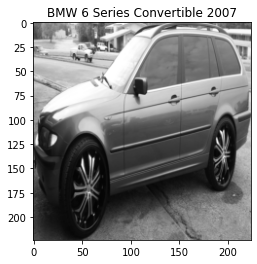

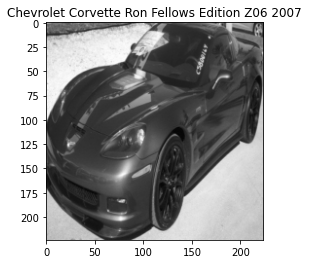

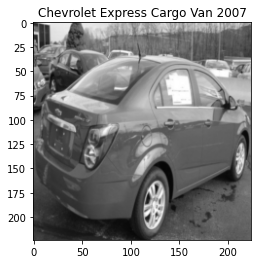

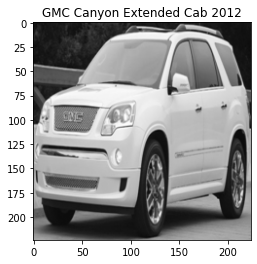

In [207]:
for i in range(4):
    image, class_number = datasets['train'][i]
    # plt.imshow(torch.Tensor(image).permute(1, 2, 0).numpy())
    plt.imshow(np.transpose(image, (1, 2, 0)), cmap='gray')
    plt.title(datasets['train'].classes[class_number])
    plt.show()

In [ ]:
"""
min_h = 10000
indexes_less_than_3_channels = []
for i, (tensor, label) in enumerate(dataset_with_labels):
    c, h, w = tensor.shape
    min_h = min(h, min_h)
    if c < 3:
        indexes_less_than_3_channels.append(i)
        if c != 1:
            print(f"unexpected_number_of_channels: {c}")
print(f"min_h = {min_h}")
print(indexes_less_than_3_channels)
"""

In [149]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            #running_corrects = 0
            all_true_labels = []
            all_preds = []
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                #running_corrects += torch.sum(preds == labels.data)

                all_true_labels.extend(labels.tolist())
                all_preds.extend(preds.tolist())

            epoch_loss = running_loss / len(image_datasets[phase])
            # epoch_acc = running_corrects.double() / len(image_datasets[phase])
            epoch_f_score = f1_score(all_true_labels, all_preds, average = 'macro')

            print(f"{phase} loss: {epoch_loss:.4f}, f_score: {epoch_f_score:.4f}")
    return model

In [150]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [151]:
n_classes = len(datasets['train'].classes)
model = torchvision.models.resnet101()
model.fc = torch.nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

In [152]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters())

In [180]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)


Epoch 1/3
----------


  0%|                                                                               | 9/6922 [00:14<3:10:59,  1.66s/it]


KeyboardInterrupt: 